# Import Modules

In [75]:
# import modules
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_validate
from lightgbm import LGBMRegressor
from functools import partial
import optuna

In [76]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [77]:
# set font size
plt.rcParams['font.size'] = 18

# Dataset

In [101]:
# read train, test, and submission files
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

**train**
- "id"
    - 4658147 samples
- "molecule_name"
    - 85003 samples
- "atom_index_0", "atom_index_1"
    - 0~28
- "type"
    - 1JHC, 1JHN, 2JHH, 2JHC, 2JHN, 3JHH, 3JHC, 3JHN
- "scalar_coupling_constant"
    - target feature

**test**
- "id"
    - 2505542 samples
- "molecule_name"
    - 45772 samples
- "atom_index_0", "atom_index_1"
    - 0~28
- "type"
    - 1JHC, 1JHN, 2JHH, 2JHC, 2JHN, 3JHH, 3JHC, 3JHN

**sample_submission**
- "id"
    - 2505542 samples
- "scalar_coupling_constant"

In [88]:
# read files for train data
dipole_moments = pd.read_csv('../data/dipole_moments.csv')
magnetic_shielding_tensors = pd.read_csv('../data/magnetic_shielding_tensors.csv')
mulliken_charges = pd.read_csv('../data/mulliken_charges.csv')
potential_energy = pd.read_csv('../data/potential_energy.csv')
scalar_coupling_contributions = pd.read_csv('../data/scalar_coupling_contributions.csv')

**dipole_moments**
- "molecule_name"
    - 85003 samples
- "X", "Y", "Z"

**magnetic_shielding_tensors**
- "molecule_name"
    - 85003 samples
- "atom_index"
    - 0~28
- "XX", "YX", "ZX", "XY", "YY", "ZY", "XZ", "YZ", "ZZ"

**mulliken_charges**
- "molecule_name"
    - 85003 samples
- "atom_index"
    - 0~28
- "mulliken_charge"

**potential_energy**
- "molecule_name"
    - 85003 samples
- "potential_energy"

**scalar_coupling_contributions**
- "molecule_name"
    - 85003 samples
- "atom_index_0", "atom_index_1"
    - 0~28
- "type"
    - 1JHC, 1JHN, 2JHH, 2JHC, 2JHN, 3JHH, 3JHC, 3JHN
- "fc"
    - Fermi Contact contribution
- "sd"
    - Spin-dipolar contribution
- "pso"
    - Paramagnetic spin-orbit contribution
- "dso"
    - Diamagnetic spin-orbit contribution

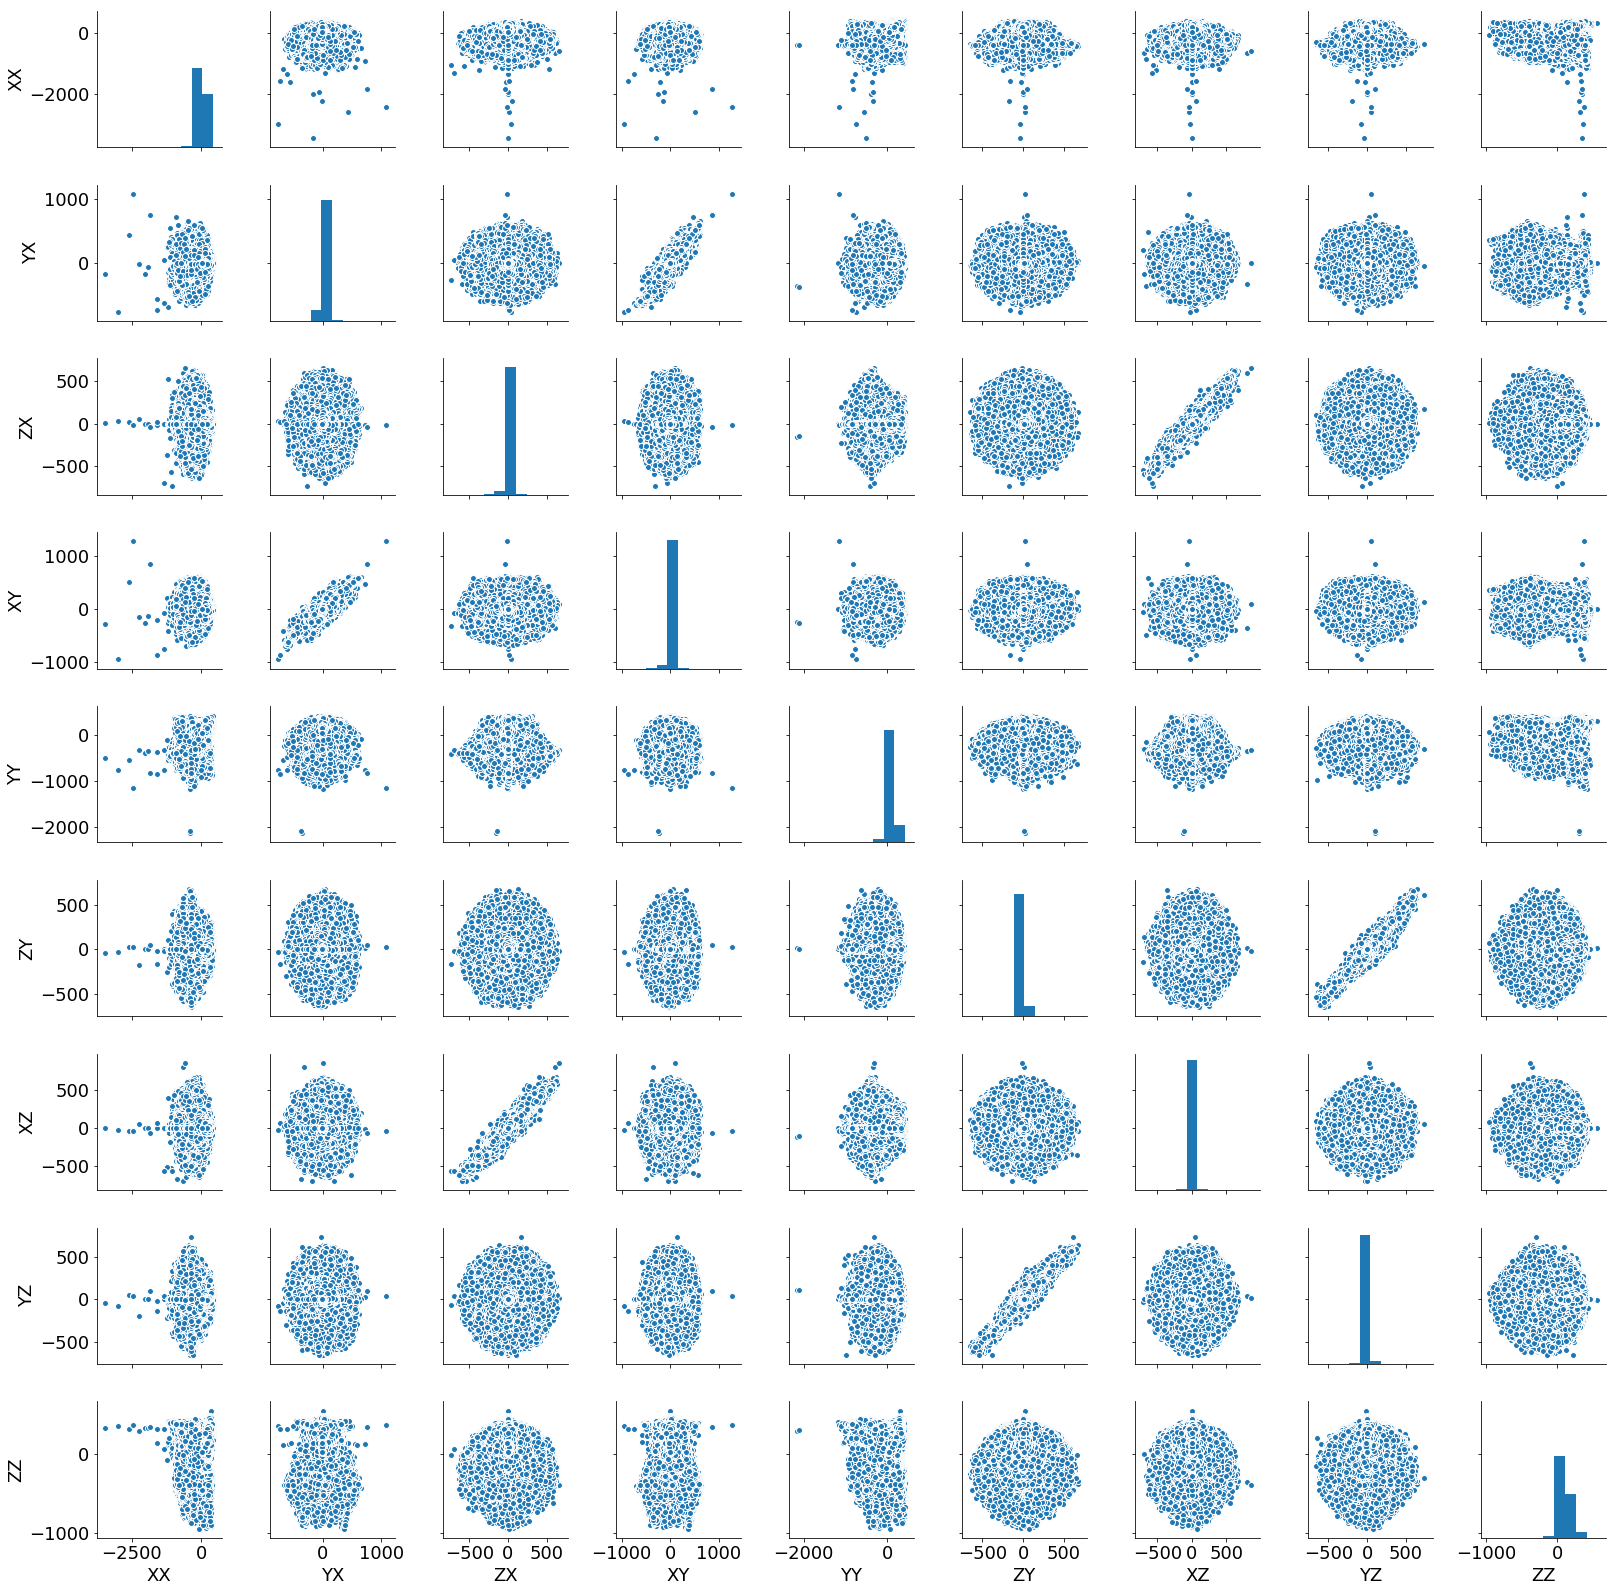

In [156]:
sns.pairplot(magnetic_shielding_tensors[['XX', 'YX', 'ZX', 'XY', 'YY', 'ZY', 'XZ', 'YZ', 'ZZ']])

In [80]:
# read file for train and test data
structures = pd.read_csv('../data/structures.csv')

**structures**
- "molecule_name"
    - 130775 ( train + test ) samples
- "atom_index"
    - 0~28
- "atom"
    - C, H, N, O, F
- "x", "y", "z"

# Data Explanation

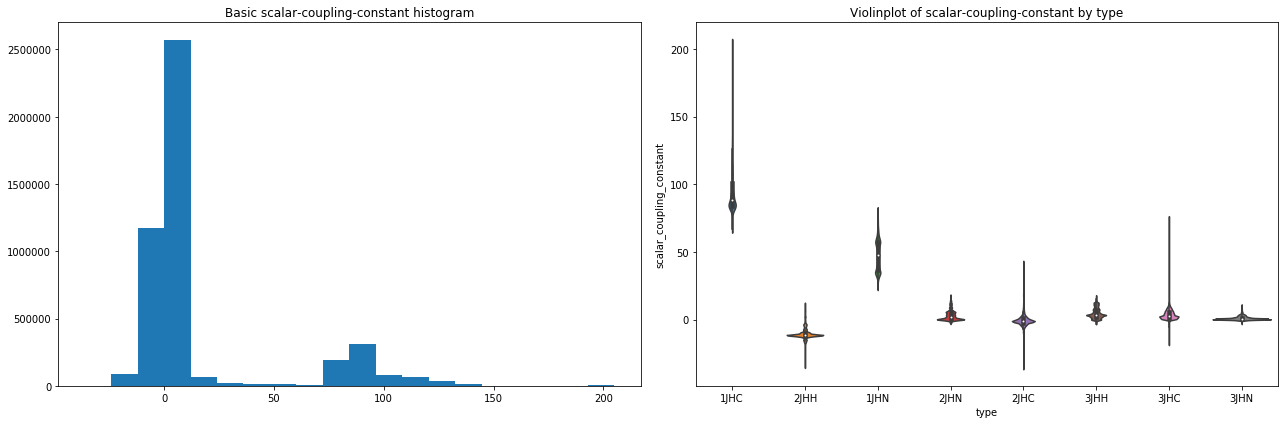

In [5]:
# scalar-coupling-constant histogram and violinplot of scalar-coupling-constant by type
fig, ax = plt.subplots(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.hist(train['scalar_coupling_constant'], bins=20)
plt.title('Basic scalar-coupling-constant histogram')
plt.subplot(1, 2, 2)
sns.violinplot(x='type', y='scalar_coupling_constant', data=train)
plt.title('Violinplot of scalar-coupling-constant by type')
plt.tight_layout()
plt.show()

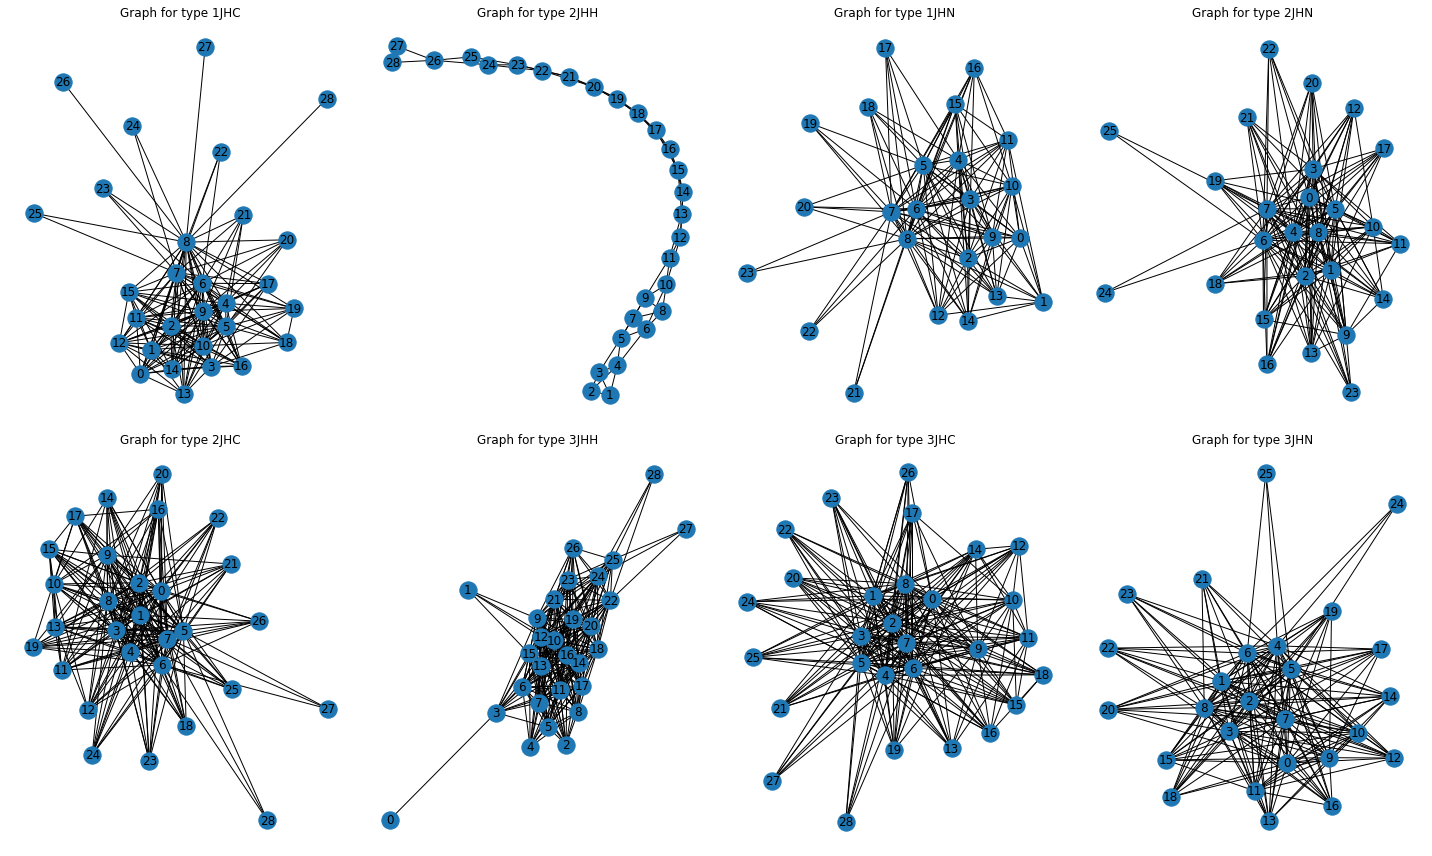

In [6]:
# network graphs by type
fig, ax = plt.subplots(figsize=(20, 12))
for i, t in enumerate(train['type'].unique()):
    train_type = train[train['type']==t]
    G = nx.from_pandas_edgelist(train_type, 'atom_index_0', 'atom_index_1', ['scalar_coupling_constant'])
    plt.subplot(2, 4, i+1)
    nx.draw(G, with_labels=True)
    plt.title(f'Graph for type {t}')
plt.tight_layout()
plt.show()

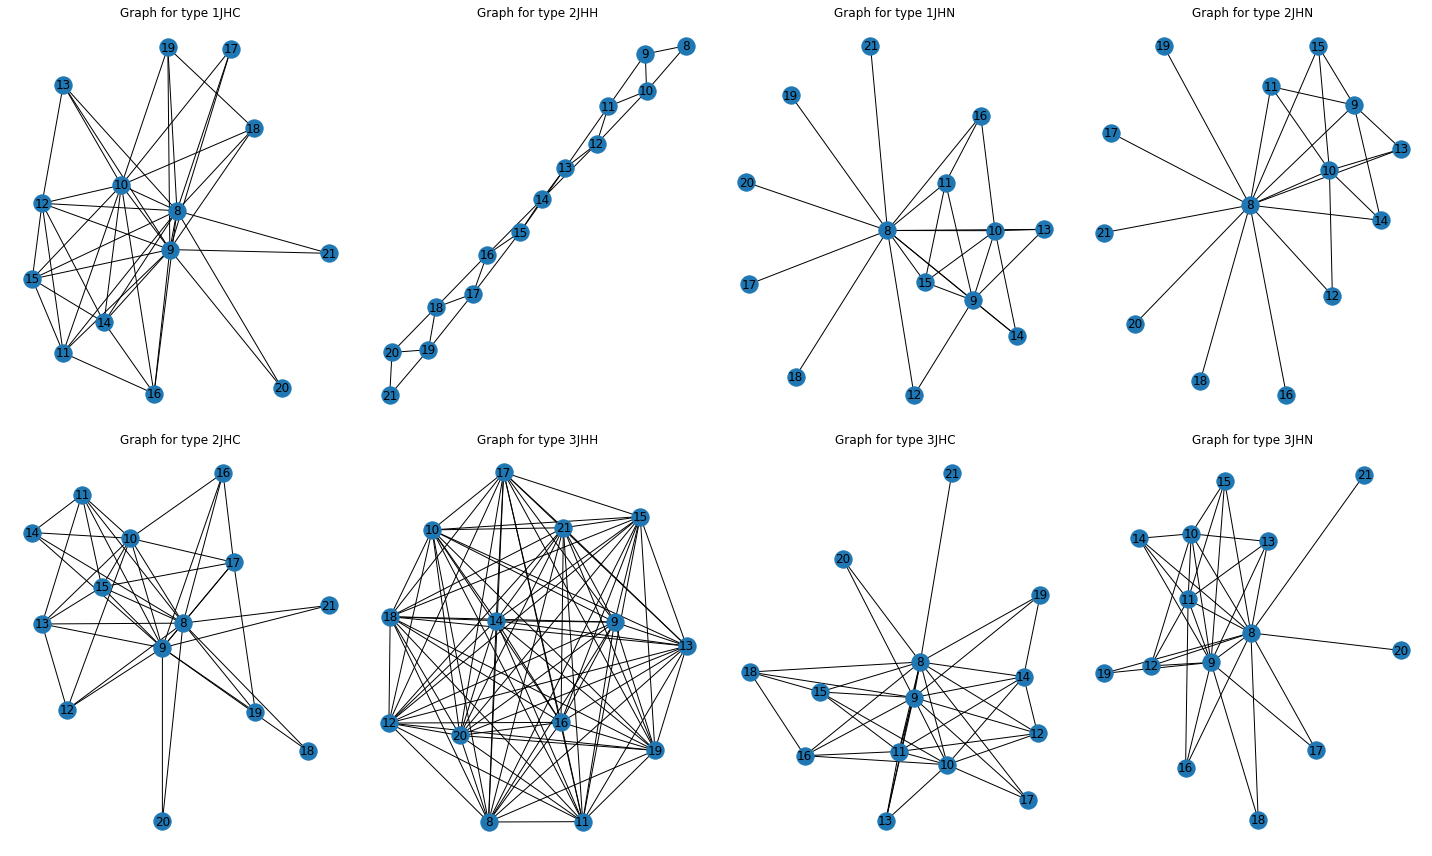

In [7]:
# better network graphs by type
fig, ax = plt.subplots(figsize=(20, 12))
for i, t in enumerate(train['type'].unique()):
    train_type = train[train['type']==t]
    train_atoms_0 = train['atom_index_0'].value_counts(normalize=True)
    train_atoms_1 = train['atom_index_0'].value_counts(normalize=True)
    bad_atoms_0 = list(train_atoms_0[train_atoms_0<0.01].index)
    bad_atoms_1 = list(train_atoms_1[train_atoms_1<0.01].index)
    train_type = train_type[(~train_type['atom_index_0'].isin(bad_atoms_0))
                            &(~train_type['atom_index_1'].isin(bad_atoms_1))]
    G = nx.from_pandas_edgelist(train_type, 'atom_index_0', 'atom_index_1', ['scalar_coupling_constant'])
    plt.subplot(2, 4, i+1)
    nx.draw(G, with_labels=True)
    plt.title(f'Graph for type {t}')
plt.tight_layout()
plt.show()

# Feature Engineering

In [8]:
# map information of atoms
def map_atom_info(df, index):
    df = pd.merge(df, structures, how='left',
                  left_on=['molecule_name', f'atom_index_{index}'],
                  right_on=['molecule_name', 'atom_index'])
    df = df.drop(columns='atom_index')
    df = df.rename(columns={'atom': f'atom_{index}',
                            'x': f'x_{index}',
                            'y': f'y_{index}',
                            'z': f'z_{index}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [9]:
# add distance between two atoms
def add_distance(df):
    p_0 = df[['x_0', 'y_0', 'z_0']].values
    p_1 = df[['x_1', 'y_1', 'z_1']].values
    df['dist'] = np.linalg.norm(p_0-p_1, axis=1)
    df['dist_x'] = (df['x_0'] - df['x_1']) ** 2
    df['dist_y'] = (df['y_0'] - df['y_1']) ** 2
    df['dist_z'] = (df['z_0'] - df['z_1']) ** 2
    return df

train = add_distance(train)
test = add_distance(test)

In [10]:
# devide type into number and charactor
def devide_type(df):
    df['type_0'] = df['type'].apply(lambda x: x[0])
    df['type_1'] = df['type'].apply(lambda x: x[1:])
    return df

train = devide_type(train)
test = devide_type(test)

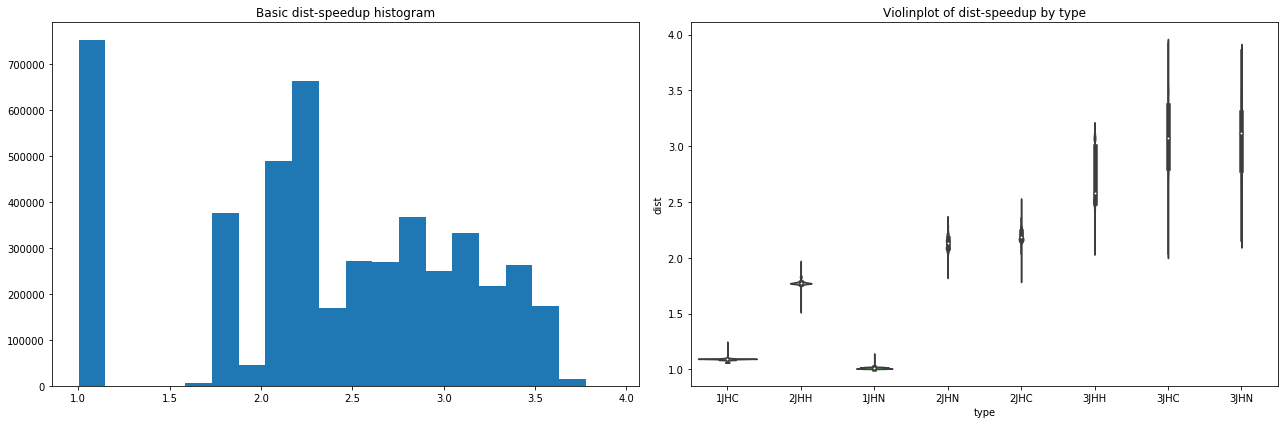

In [11]:
# dist-speedup histogram and violinplot of dist-speedup by type
fig, ax = plt.subplots(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.hist(train['dist'], bins=20)
plt.title('Basic dist-speedup histogram')
plt.subplot(1, 2, 2)
sns.violinplot(x='type', y='dist', data=train)
plt.title('Violinplot of dist-speedup by type')
plt.tight_layout()
plt.show()

In [12]:
# normalize distance by type
def distance_normalization(df):
    df['dist_to_type_mean'] = df['dist'] / df.groupby('type')['dist'].transform('mean')
    df['dist_to_type_0_mean'] = df['dist'] / df.groupby('type_0')['dist'].transform('mean')
    df['dist_to_type_1_mean'] = df['dist'] / df.groupby('type_1')['dist'].transform('mean')
    return df

train = distance_normalization(train)
test = distance_normalization(test)

In [13]:
# label encode
for col in ['atom_0', 'atom_1', 'type_0', 'type_1', 'type']:
    lbe = LabelEncoder()
    lbe.fit(list(train[col].values)+list(test[col].values))
    train[col] = lbe.transform(list(train[col].values))
    test[col] = lbe.transform(list(test[col].values))

In [14]:
# make explantory and target variables
X = train.drop(columns=['id', 'molecule_name', 'scalar_coupling_constant', 'atom_index_0', 'atom_index_1'])
y = train['scalar_coupling_constant']
X_test = test.drop(columns=['id', 'molecule_name', 'atom_index_0', 'atom_index_1'])

# Model Learning

In [62]:
# tuning parameters with optuna
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 1e+1, 1e+2),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
    }
    model = LGBMRegressor(**params)
    kf = KFold(n_splits=5, shuffle=True, random_state=81)
    scores = cross_validate(model, X=X, y=y, cv=kf)
    return 1.0 - scores['test_score'].mean()

f = partial(objective)
study_name = 'lgb_study'
study = optuna.create_study(study_name=study_name, storage='sqlite:///../database/lgb.db', load_if_exists=True)
study.optimize(f, n_trials=1)
print('params:', study.best_params)

[I 2019-06-02 23:41:27,173] Using an existing study with name 'lgb_study' instead of creating a new one.
[I 2019-06-02 23:43:21,673] Finished trial#1 resulted in value: 0.01293387804172852. Current best value is 0.012440454374954668 with parameters: {'max_depth': 5, 'num_leaves': 70}.


params: {'max_depth': 5, 'num_leaves': 70}


# Prediction

In [63]:
# predict with best model
model = LGBMRegressor(**study.best_params)
model.fit(X, y)
prediction = model.predict(X_test)

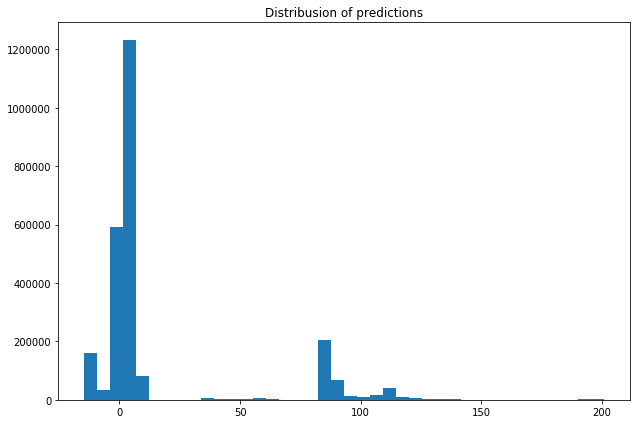

In [64]:
# distribution of predictions
plt.figure(figsize=(9, 6))
plt.hist(prediction, bins=40)
plt.title('Distribusion of predictions')
plt.tight_layout()
plt.show()

# Submission

In [65]:
# make submission file
submission['scalar_coupling_constant'] = prediction
# submission.to_csv('../results/submission.csv', index=False)